In [2]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as ssim

In [3]:
def mgrid(len, dim = 2):
    t = []
    for i in range(dim):
        lin = tf.linspace(-1, 1, len)
        t.append(lin)
    mesh = tf.meshgrid(*t, indexing = "ij")
    mgrid = tf.stack(mesh, axis = -1)
    mgrid = tf.reshape(mgrid, [-1,dim])
    return mgrid

In [4]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, is_first = False, omega_0 = 30, use_bias = True, **kwargs):
        super(SineLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.is_first = is_first
        self.omega_0 = omega_0
        self.use_bias = use_bias
        
    def build(self, input_shape):
        if self.is_first:
            limit = 1/self.in_features
        else:
            limit = np.sqrt(6/self.in_features)/self.omega_0
        self.w = self.add_weight(shape = (self.in_features, self.out_features), initializer = tf.keras.initializers.RandomUniform(minval = -limit, maxval = limit), trainable = True, name = 'weights')
        if self.use_bias:
            self.b = self.add_weight(shape = (self.out_features, ), initializer = tf.keras.initializers.Zeros(), trainable = True, name = 'bias')
        else:
            self.b = None
            
    def call(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        if self.b is not None:
            x += self.b
        return tf.sin(self.omega_0 * x)
        
    def call_with_intermediate(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        if self.b is not None:
            x += self.b
        intermediate = self.omega_0 * x
        return tf.sin(intermediate), intermediate

In [5]:
class FinerLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, is_first = False, omega_0 = 2.5, k =10, **kwargs):
        super(FinerLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.is_first = is_first
        self.omega_0 = omega_0
        self.k = k
    def build(self, input_shape):
        if self.is_first:
            limit = 1/self.in_features
        else:
            limit = np.sqrt(6/self.in_features)/self.omega_0
        self.w = self.add_weight(shape = (self.in_features, self.out_features), initializer = tf.keras.initializers.RandomUniform(minval = -limit, maxval = limit), trainable = True, name = 'weights')
        self.b = self.add_weight(shape = (self.out_features, ), initializer = tf.keras.initializers.RandomUniform(minval = -self.k, maxval = self.k), trainable = True, name = 'bias')
    def call(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        x += self.b
        modulated = (tf.abs(x) + 1) * x
        a = tf.sin(self.omega_0 * modulated)
        return a


In [6]:
def SirenModel(input_f, output_f, hidden_features, hidden_layers, outermost_linear = False, first_omega = 30, hidden_omega = 30):
    input_img = tf.keras.Input(shape = (input_f,))
    x = SineLayer(in_features = input_f, out_features = hidden_features, is_first = True, omega_0 = first_omega, use_bias = True)(input_img)
    for i in range(hidden_layers):
        x = SineLayer(in_features = hidden_features, out_features = hidden_features, is_first = False, omega_0 = hidden_omega, use_bias = True)(x)
    if outermost_linear:
        output = tf.keras.layers.Dense(output_f, activation = 'tanh', kernel_initializer = tf.keras.initializers.RandomUniform(minval = -np.sqrt(6/hidden_features)/hidden_omega, maxval = np.sqrt(6/hidden_features)/hidden_omega))(x)
    else:
        output = SineLayer(in_features = hidden_features, out_features = output_f, is_first = False, omega_0 = hidden_omega, use_bias = True)(x)
    model = tf.keras.Model(inputs = input_img, outputs = output)
    return model


In [7]:
def FinerModel(in_f, out_features, hidden_features, hidden_layers, omega_0 = 2.5, hidden_omega_0 = 2.5, k =10, outermost_linear = False):
    Input_img = tf.keras.Input(shape =(in_f, ))
    x = FinerLayer(in_features = in_f, out_features = hidden_features,is_first = True, omega_0 = omega_0, k =k)(Input_img)
    for i in range(hidden_layers):
        x = FinerLayer(hidden_features, hidden_features, hidden_omega_0, k = k)(x)
    if outermost_linear:
        output = tf.keras.layers.Dense(out_features, activation = 'tanh', kernel_initializer = tf.keras.initializers.RandomUniform(minval = -np.sqrt(6/hidden_features)/hidden_omega_0, maxval = np.sqrt(6/hidden_features)/hidden_omega_0))(x)
    else:
        output = FinerLayer(in_features = hidden_features, out_features = out_features, omega_0 = hidden_omega_0, k = k)(x)
    model = tf.keras.Model(inputs = Input_img, outputs = output)
    return model

In [44]:
siren_model = SirenModel(input_f =2, output_f = 3, hidden_features = 256, hidden_layers = 7, outermost_linear = True, first_omega = 30, hidden_omega = 30)
siren_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_16 (SineLayer)       │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_17 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_18 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_19 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_20 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_21 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_22 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_23 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,083 (1.76 MB)

 Trainable params: 462,083 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
finer_model = FinerModel(in_f = 2, out_features =3, hidden_features = 256, hidden_layers = 7, omega_0 = 2.5, hidden_omega_0 = 2.5, outermost_linear = True)
finer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_8 (FinerLayer)      │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_9 (FinerLayer)      │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_10 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_11 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_12 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_13 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_14 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_15 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,083 (1.76 MB)

 Trainable params: 462,083 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import os 
from PIL import Image 
def bsds_tensor(sidelength, split = 'test', id = '108005', bsds_dir = "C:/Users/HP/Downloads/summer project/archive (1)/BSDS300/BSDS300/images"):
    filepath = os.path.join(bsds_dir, split, f'{id}.jpg')
    img = Image.open(filepath).convert('RGB')
    img = tf.convert_to_tensor(np.array(img)/255, dtype = tf.float32)
    #img_new = tf.image.resize(img, size=(sidelength,sidelength), method="bicubic").numpy()
    height, width = tf.shape(img)[0], tf.shape(img)[1]
    crop_x = (height - sidelength) // 2
    crop_y = (width - sidelength) // 2
    img_cropped = img[crop_x:crop_x+sidelength, crop_y:crop_y+sidelength, :]
    return img_cropped

(128, 128, 3)


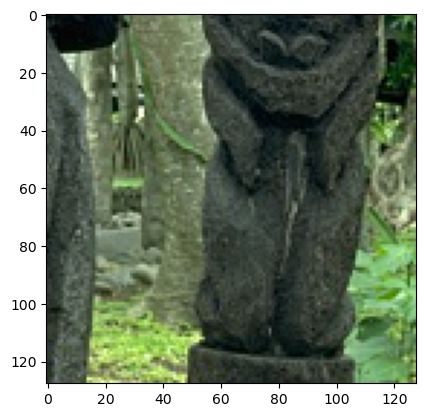

In [26]:
img = bsds_tensor(128, id = '101085')
print(img.shape)
fig = plt.figure()
plt.imshow(img)

In [34]:
class ImageFitting(tf.data.Dataset):
    def __new__(cls, sidelength, split = 'test', id = '101085', sigma = 0.1, bsds_dir = "C:/Users/HP/Downloads/summer project/archive (1)/BSDS300/BSDS300/images"):
        clean_img = bsds_tensor(sidelength, split, id, bsds_dir)
        
        coords = mgrid(sidelength)
        pixels = tf.reshape(clean_img, [-1,3])
        #dataset = tf.data.Dataset.from_tensor_slices((coords, pixels))
        #dataset = dataset.batch(sidelength * sidelength, drop_remainder = True)
        return coords, clean_img, pixels 

In [36]:
def training_model(sidelength, model, split = 'test', id = '101085', epochs = 100):
    coords, img_clean, pixels = ImageFitting(sidelength, split = split, id = id)
    img_clean = np.array(img_clean, dtype=np.float32)
    model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'mse')
    model.fit(coords, pixels, batch_size = 1024, epochs = epochs, verbose = 1)
    return img_clean, model

In [40]:
def super_resolve(model, times, in_dim):
    H_hr = times * in_dim
    coords_hr = mgrid(H_hr)
    prediction = model.predict(coords_hr, batch_size =1024)
    #prediction = tf.clip_by_value(prediction, 0., 1.)
    sr_img = tf.reshape(prediction, [H_hr, H_hr, 3])
    return sr_img.numpy()

In [48]:
#result for siner model for super resolution of order 2 
ssim_value = ssim(clean_resized, sr_image_scaled, data_range = 1, win_size = 3)
print("SSIM for Siren Model:", ssim_value)
print("psnr for Siren Model:", psnr)

SSIM for Siren Model: 0.7997352446678689
psnr for Siren Model: 15.102386613083878


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.1637
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0175
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0086
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0063
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0057
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0055
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0046
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0053
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0044
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0041
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0037
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0036
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0034
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0033
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - lo

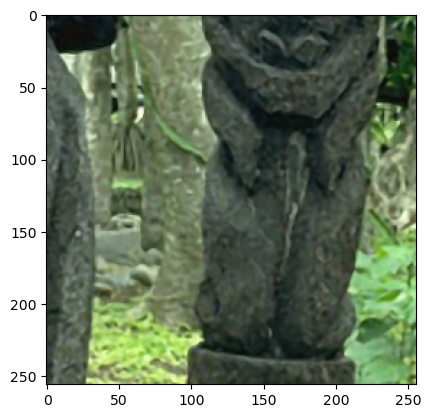

In [54]:
image_true2, finer1 = training_model(sidelength = 128, model = finer_model, split = 'test', id = '101085',epochs = 100)
clean_resized2 = tf.image.resize(image_true2, size=(128*2,128*2), method="bicubic").numpy()
sr_image2 = super_resolve(finer_model, 2, 128)
sr_image_scaled2 = (sr_image2 - sr_image2.min())/(sr_image2.max() - sr_image2.min())
plt.imshow(sr_image_scaled2)
clean_resized2 = (clean_resized2 - clean_resized2.min())/(clean_resized2.max() - clean_resized2.min())
psnr2 = compare_psnr(clean_resized2, sr_image_scaled2)

In [56]:
# result for finer model for super resolution of order 2 
ssim_value2 = ssim(clean_resized2, sr_image_scaled2, data_range = 1, win_size = 3)
print("SSIM for Finer Model:", ssim_value2)
print("psnr for Finer Model:", psnr2)

SSIM for Finer Model: 0.932741693440164
psnr for Finer Model: 27.344741815841736


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step


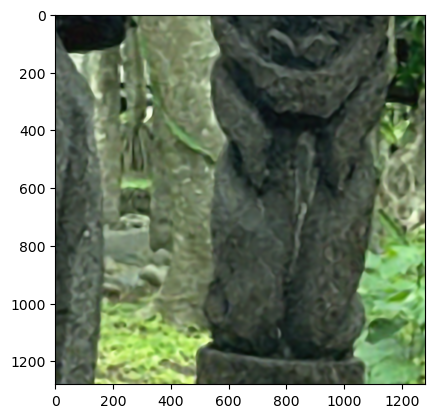

In [62]:
clean_resized2 = tf.image.resize(image_true2, size=(128*10,128*10), method="bicubic").numpy()
sr_image2 = super_resolve(finer_model, 10, 128)
sr_image_scaled2 = (sr_image2 - sr_image2.min())/(sr_image2.max() - sr_image2.min())
plt.imshow(sr_image_scaled2)
clean_resized2 = (clean_resized2 - clean_resized2.min())/(clean_resized2.max() - clean_resized2.min())
psnr2 = compare_psnr(clean_resized2, sr_image_scaled2)

In [64]:
# result for finer model for super resolution of order 10
ssim_value2 = ssim(clean_resized2, sr_image_scaled2, data_range = 1, win_size = 3)
print("SSIM for Finer Model:", ssim_value2)
print("psnr for Finer Model:", psnr2)

SSIM for Finer Model: 0.9540960503665248
psnr for Finer Model: 25.947786687612776


In [72]:
def results(image_true, sidelength, order, model):
    clean_resized = tf.image.resize(image_true, size=(128*order,128*order), method="bicubic").numpy()
    sr_image = super_resolve(model, order, sidelength)
    sr_image_scaled = (sr_image - sr_image.min())/(sr_image.max() - sr_image.min())
    clean_resized = (clean_resized - clean_resized.min())/(clean_resized.max() - clean_resized.min())
    ssim_value = ssim(clean_resized, sr_image_scaled, data_range = 1, win_size = 3)
    psnr = compare_psnr(clean_resized, sr_image_scaled)
    return psnr, ssim_value

In [76]:
import pandas as pd
rows = ["PSNR", "SSIM"]
cols = list(range(2, 11))
df_siren = pd.DataFrame(index=rows, columns=cols)
for i in range(2,11):
    df_siren.loc["PSNR", i], df_siren.loc["SSIM", i] = results(image_true, 128, i, siren_model)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
784/784 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step


In [80]:
print("siren model results for super resolution")
print(df_siren)

siren model results for super resolution
             2          3          4          5          6          7   \
PSNR  15.102387  15.292709  15.134929  15.198448  15.119902  15.180844   
SSIM   0.799735   0.816155   0.823079   0.834517   0.837944   0.844417   

             8          9          10  
PSNR  15.152638  15.156107  15.148013  
SSIM   0.846566   0.849421   0.850823  


In [84]:
rows = ["PSNR", "SSIM"]
cols = list(range(2, 11))
df_finer = pd.DataFrame(index=rows, columns=cols)
for i in range(2,11):
    df_finer.loc["PSNR", i], df_finer.loc["SSIM", i] = results(image_true, 128, i, finer_model)
print("siren model results for super resolution")
print(df_finer)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step
784/784 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step
siren model results for super resolution
             2         3          4          5          6          7   \
PSNR  27.344742  26.96773  26.502278  26.355177  26.131657  26.135918   
SSIM   0.932742  0.930546   0.936935   0.941134   0.945484   0.948437   

             8          9          10  
PSNR  26.048175  26.006367  25.947787  
SSIM   0.950965   0.952618   0.954096  
